In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. Tổng quan**

**Một vấn đề** tồn tại đối với bất kỳ trang web lớn nào hiện nay là làm thế nào để xử lý các nội dung độc hại và dễ gây chia rẽ. Quora, một nền tảng cho phép mọi người có thể đặt câu hỏi và kết nối với những người khác để nhận được câu trả lời chất lượng. Tuy nhiên, vẫn có tồn tại những câu hỏi nhạy cảm, có ý đồ gây chia rẽ , thay vì muốn tìm câu trả lời hữu ích. Vì vậy, ta cần phải xây dựng một mô hình phân loại được giữa những câu hỏi chân thành, mục đích tốt (Sincere) với những câu hỏi mang tính tiêu cực, không đúng đắn ấy (Insincere).

**Input**: Câu hỏi trên Quora (text)

**Output**: Nhãn Sincere hoặc Insincere

# **2. Xử lý dữ liệu**

**2.1. Phân tích dữ liệu**

Dữ liệu vào là các câu hỏi trên Quora. Nhiệm vụ phải làm là phân loại các câu hỏi ấy.
Một câu hỏi bao gồm các thuộc tính:
* qid : id duy nhất nhận diện câu hỏi.
* question_text: câu hỏi dạng text.
* target: nhãn của câu hỏi, có giá trị là 1 nếu là "insincere", ngược lại là 0.

Khi phân loại, ta dùng thuộc tính question_text là đầu vào X, target là đầu ra nhãn Y.

In [ ]:
train_data = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_data = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")

#Tập train
train_data

In [ ]:
#Lấy ra tập câu hỏi có nhãn 1(Insincere)
insincere_data = train_data[train_data.target == 1]
#Lấy ra tập câu hỏi có nhãn 0(Sincere)
sincere_data = train_data[train_data.target == 0]

In [ ]:
train_data.info()

**Phân tích tỉ lệ câu hỏi Sincere và Insincere trong tập train**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

temp = train_data['target'].value_counts(normalize=True).reset_index()

colors = ['#4f92ff', '#4ffff0']
explode = (0.05, 0.05)
 
plt.pie(temp['target'], explode=explode, labels=temp['index'], colors=colors,
         autopct='%1.1f%%', shadow=True, startangle=0)
 
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.suptitle('% Target', fontsize=16)
plt.axis('equal')
plt.show()
print("--------------------------")
print( "Dữ liệu Insincere chiếm", insincere_data.shape[0] / train_data.shape[0] * 100)
print( "Dữ liệu Sincere chiếm", sincere_data.shape[0] / train_data.shape[0] * 100)

**Phân tích các từ xuất hiện nhiều nhất bằng n-gram** : là tần suất xuất hiện của n kí tự ( hoặc từ ) liên tiếp nhau có trong dữ liệu của corpus.
* unigram, mô hình với n=1, tức là ta sẽ tính tần suất xuất hiện của một kí tự (từ), như: “k”, “a”,…
* bigrams với n=2, mô hình được sử dụng nhiều trong việc phân tích các hình thái cho ngôn ngữ, ví dụ với các chữ cái tiếng Anh, ‘th’,’he’,’in’,’an’,’er’ là các cặp kí tự hay xuất hiện nhất.
* trigrams với n=3.

In [ ]:
from wordcloud import STOPWORDS
from collections import defaultdict
import seaborn as sns

def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Lấy max_row các từ dạng n_gram xuất hiện nhiều nhất trong dữ liệu
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

def comparison_plot(df_1,df_2,col_1,col_2):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0])
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1])

    ax[0].set_xlabel('Word count', size=12)
    ax[0].set_ylabel('Words', size=12)
    ax[0].set_title('Top words in sincere questions', size=16)

    ax[1].set_xlabel('Word count', size=12)
    ax[1].set_ylabel('Words', size=12)
    ax[1].set_title('Top words in insincere questions', size=16)

    fig.subplots_adjust(wspace=0.25)
    
    plt.show()

In [ ]:
#Lấy ra 20 từ dạng unigram xuất hiện nhiều nhất trong 2 loại tập câu hỏi
sincere_1gram = generate_ngrams(sincere_data, 'question_text', 1, 20)
insincere_1gram = generate_ngrams(insincere_data, 'question_text', 1, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount')

In [ ]:
#Lấy ra 20 từ dạng bigram xuất hiện nhiều nhất trong 2 loại tập câu hỏi
sincere_2gram = generate_ngrams(sincere_data, 'question_text', 2, 20)
insincere_2gram = generate_ngrams(insincere_data, 'question_text', 2, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount')

In [ ]:
#Lấy ra 10 từ dạng trigram xuất hiện nhiều nhất trong 2 loại tập câu hỏi
sincere_3gram = generate_ngrams(sincere_data, 'question_text', 3, 20)
insincere_3gram = generate_ngrams(insincere_data, 'question_text', 3, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount')

**2.2. Nhận xét dữ liệu**

**Tập dữ liệu train gồm 1306122 câu hỏi**:
* 93.8% trong số đó là câu hỏi là Sincere, còn lại là Insincere.
* Những câu hỏi Insincere đa phần bao gồm các từ như trump, women, white, men, indian, muslims, black, americans, girls, indians, sex and india => nhắm tới nhóm người hay người cụ thể.
* Top 3 câu hỏi Insincere bigram là "Donald Trump", "White People", "Black People" => các câu hỏi liên quan đến chủng tộc.
* Các câu hỏi Insincere xoay quanh các tình huống giả định, tuổi tác, chủng tộc, v.v.
* Các câu hỏi Sincere liên quan đến mẹo, lời khuyên, gợi ý, sự thật, v.v.

**2.3. Clean dữ liệu**

**Clean dữ liệu cần:**
* Unicode: chuyển về dạng unicode.
* Lowercase: chuyển về chữ in thường.
* Remove link, punctuation, number: bỏ dấu, chữ số, link
* Tokenization: phân tách một câu thành các tokens (các từ, cụm từ,... có nghĩa).
* Stemming hoặc Lemmazation: chuyển đổi, rút gọn các từ về từ gốc (ate, eaten thành eat).
* Remove stopword: loại bỏ các stopword (a, an, or, of, the, ...).

In [ ]:
#Sử dụng thư viện nltk(Natural Language Toolkit)
import re
import nltk
import string
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import STOPWORDS

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"}

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean(text):        
    # chuyển về dạng unicode 
    text = unidecode(text).encode("ascii")
    text = str(text, "ascii")

    # chuyển về chữ thường, bỏ các link, kí tự đặc biệt, chữ số.
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', ' ', text)  
    text = ''.join(i for i in text if not i.isdigit())

    # Chuyển các từ viết tắt trong từ điển về dạng thường
    tokens = word_tokenize(text)
    tokens = [mispell_dict.get(token) if (mispell_dict.get(token) != None) else token for token in tokens]
    text = " ".join(tokens)

    # Bỏ stop-words   
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in STOPWORDS]

    # Chuyển biến thể ngữ pháp của từ về từ gốc
    text = [lemmatizer.lemmatize(word) for word in tokens_without_sw ] 
    text = " ".join(text)

    return text

In [ ]:
#Thêm cột clean_questions về các câu hỏi đã clean vào tập train
train_data['clean_questions'] = train_data['question_text'].apply(clean)
train_data

**2.4. Convert dữ liệu**

Áp dụng CountVectorizre, convert dữ liệu text về dạng vector của số lần xuất hiện của các token. Bag-of-Words là kỹ thuật cốt lõi cho vấn đề này, các phương pháp bao gồm:
* Tách dữ liệu thành các token
* Xác định trọng số cho mỗi token ứng với số lần xuất hiện của nó.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X = train_data['clean_questions']
Y = train_data['target']

count_vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

count_train = count_vectorizer.fit(X)

X_vec_train = count_train.transform(X_train)
X_vec_test = count_train.transform(X_test)

# **3. Huấn luyện mô hình**

**Sử dụng mô hình Hồi quy Logistic (Logistic Regression)**: https://excessive-source-1c9.notion.site/18-09-2021-H-i-quy-Logistics-6c3eb44266e549169a0d01cc2d36cfa2
* Với input tập câu hỏi sau khi clean và convert **X_train_vec $\in$ $R^d$**, output là nhãn **Y_train $\in \{0, 1\}$**.
* Mô hình: $Y|X=x \sim Ber(y|\sigma(f(x))$ với $f(x) = w^Tx+w_0$
* Cho $f(x)$ đi qua hàm sigmoid: $\sigma(z) = \frac 1 {1+e^{-z}}$
* Huấn luyện bộ tham số của mô hình $\theta = (w, w_0)$: Tính Likelihood => Tính hàm lỗi Negative Loglikelihood (NLL) => Xuống đồi bằng đạo hàm cập nhật bộ tham số.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score ,f1_score
from sklearn.metrics import classification_report

mod = LogisticRegression(n_jobs=10, solver='saga',class_weight = 'balanced', C=0.1, verbose=1)
mod.fit(X_vec_train, Y_train)
Y_pred = mod.predict(X_vec_test)

**Sự dụng F1-score làm metric**
* Trung bình điều hòa giữa precision (độ chính xác) và recall (độ bao phủ). $\frac {2}{F_1} = \frac {1}{Precision} + \frac {1}{Recall}$
* Precision: đánh giá bao nhiêu % kết luận của model là chính xác-True. $Precision = \frac{TP}{TP+FP}$
* Recall: đánh giá bao nhiêu % positive samples mà model nhận được. $Recall = \frac{TP}{TP+FN}$

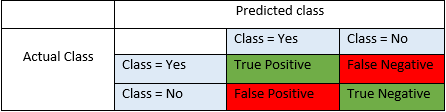


In [ ]:
print('Recall: ', recall_score(Y_pred, Y_test))
print('F1 score :', f1_score(Y_pred, Y_test), '\n')
print(classification_report(Y_test, Y_pred))

# 4. Submit

In [ ]:
test_data['clean_questions'] = test_data['question_text'].apply(clean)
X_test_vec = count_vectorizer.transform(test_data['clean_questions'])
predictions = mod.predict(X_test_vec)
submission = pd.DataFrame({'qid': test_data['qid'].values})
submission['prediction'] = predictions
submission.to_csv('submission.csv', index=False)

In [ ]:
submission